In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import meerkat as mk
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score

from domino.data.cxr import get_dp, build_cxr_df, get_cxr_activations

import umap


/home/ksaab/Documents/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


In [6]:
# Get a mosaic DataPanel with the data.
df = build_cxr_df(root_dir="/media/4tb_hdd/siim") #.out(load=True)
dp = get_dp(df)
#dp.head()

In [7]:
dp.lz[0]

{'image_id': '1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819',
 'encoded_pixels': '-1',
 'pmx': 0,
 'filepath': '/media/4tb_hdd/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.6904.1517875201.850818/1.2.276.0.7230010.3.1.3.8323329.6904.1517875201.850817/1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819.dcm',
 'chest_tube': nan,
 'split': 'train',
 'gaze_max_visit': nan,
 'gaze_unique': nan,
 'gaze_time': nan,
 'gaze_diffusivity': nan,
 'expert_label': nan,
 'index': '0',
 'input': LambdaCell(fn=cxr_loader),
 'img': LambdaCell(fn=cxr_pil_loader)}

In [42]:
model_pth = "/home/ksaab/Documents/domino/scratch/khaled/results/method_cnc/gaze_split_True/target_pmx/subgroup__chest_tube/lr_1e-05/wd_0/dropout_0/cw_1.0/domino/82w27ory/checkpoints/epoch=6-step=5709.ckpt"

dp_erm = get_cxr_activations(dp=dp, model_path=model_pth, run_type="domino")
#dp_erm.head()

  0%|          | 0/189 [00:00<?, ?it/s]

## save a dp with mimic prediction columns 

In [43]:
# # # get mimic activations
# model_pth = "/home/ksaab/Documents/domino/scratch/khaled/outputs/08-10_sabri_mimic/model_chkpt_runid4495.pt"
# dp_mimic = get_cxr_activations(dp=dp, model_path=model_pth, run_type="mimic")

In [44]:
# mimic_labels = [
#     "atelectasis",
#     "cardiomegaly",
#     "consolidation",
#     "edema",
#     "enlarged_cardio",
#     "fracture",
#     "lung_opacity",
#     "pleural_effusion",
#     "pleural_other",
#     "pneumonia",
#     "pneumothorax",
#     "support_devices",
#     "lung_lesion",
#     "no_finding",
# ]


# mimic_probs = dp_mimic["output"].data.softmax(1)
# mimic_probs[:,11] = 0 # remove support devices
# mimic_probs[:,10] = 0 # remove pmx
# mimic_preds = mimic_probs.argmax(1).numpy()

# dp_withmimic = dp
# for ndx, mimic_label in enumerate(mimic_labels):
#     if not(mimic_label in ["pneumothorax", "support_devices"]):
#         binary_preds = mimic_preds == ndx
#         dp_withmimic[mimic_label] = binary_preds

# mk.DataPanel.write(dp_withmimic,path="/media/4tb_hdd/siim/mimic_dp_09-06-21.dp")
# dp_withmimic.head()

## ERM Performance

In [45]:
dp_ = dp_erm

test_mask = dp["split"].data=="test" #np.logical_and(~train_mask, ~np.isnan(dp["chest_tube"]))
train_mask = np.logical_and(~test_mask,dp["chest_tube"].data.astype(str) != "nan") #~np.isnan(dp["gaze_seq"].data) #dp["gaze_seq"].data != "nan"


test_dp = dp_[test_mask]
train_dp = dp_[train_mask]

# overall performance
if test_dp["output"].data.shape[1] == 4:
    # classes: 0: no tube no pmx, 1: no tube pmx, 2: tube no pmx, 3: tube pmx
    test_probs = test_dp["output"].data.softmax(1)
    test_probs = np.max(test_probs[:,[1,3]].numpy(),axis=1)
    train_probs = train_dp["output"].data.softmax(1)
    train_probs = np.max(train_probs[:,[1,3]].numpy(),axis=1)
    
else:
    test_probs = test_dp["output"].data[:,1].sigmoid()
    train_probs = train_dp["output"].data[:,1].sigmoid()

test_labels = test_dp["pmx"].data
tubes_mask = np.array(test_dp["chest_tube"] == 1)
notubes_mask = np.array(test_dp["chest_tube"] == 0)

train_labels = train_dp["pmx"].data
train_tubes_mask = np.array(train_dp["chest_tube"] == 1)
train_notubes_mask = np.array(train_dp["chest_tube"] == 0)

print(len(test_labels))
print(len(train_labels))

1000
951


In [46]:
print("Train set:")
print(f"\tOverall AUROC: {roc_auc_score(train_labels,train_probs):.3f}")

neg_mask = np.array(train_labels == 0)
pos_mask = np.array(train_labels == 1)
tube_in_pos_mask = np.logical_or(neg_mask,np.logical_and(pos_mask,train_tubes_mask))
notube_in_pos_mask = np.logical_or(neg_mask,np.logical_and(pos_mask,train_notubes_mask))

tube_in_neg_mask = np.logical_or(pos_mask,np.logical_and(neg_mask,train_tubes_mask))
notube_in_neg_mask = np.logical_or(pos_mask,np.logical_and(neg_mask,train_notubes_mask))

mask = np.logical_or(np.logical_and(pos_mask,train_notubes_mask), np.logical_and(neg_mask,train_tubes_mask))
print(f"\tAll negatives have tubes, All positives have no tube, AUROC: {roc_auc_score(train_labels[mask],train_probs[mask]):.3f}")


print("Val set:")
print(f"\tOverall AUROC: {roc_auc_score(test_labels,test_probs):.3f}")

# # AUROC performance on subset that has tube labels

# print(f"With tubes AUROC: {roc_auc_score(test_labels[tubes_mask],test_probs[tubes_mask]):.3f}")

# # AUROC performance on subset that has no tube labels
# print(f"Without tubes AUROC: {roc_auc_score(test_labels[notubes_mask],test_probs[notubes_mask]):.3f}")

neg_mask = np.array(test_labels == 0)
pos_mask = np.array(test_labels == 1)
tube_in_pos_mask = np.logical_or(neg_mask,np.logical_and(pos_mask,tubes_mask))
notube_in_pos_mask = np.logical_or(neg_mask,np.logical_and(pos_mask,notubes_mask))

#print(f"All positives have tubes, AUROC: {roc_auc_score(test_labels[tube_in_pos_mask],test_probs[tube_in_pos_mask]):.3f}")
#print(f"All positives have no tubes, AUROC: {roc_auc_score(test_labels[notube_in_pos_mask],test_probs[notube_in_pos_mask]):.3f}")

tube_in_neg_mask = np.logical_or(pos_mask,np.logical_and(neg_mask,tubes_mask))
notube_in_neg_mask = np.logical_or(pos_mask,np.logical_and(neg_mask,notubes_mask))

#print(f"All negatives have tubes, AUROC: {roc_auc_score(test_labels[tube_in_neg_mask],test_probs[tube_in_neg_mask]):.3f}")
#print(f"All negatives have no tubes, AUROC: {roc_auc_score(test_labels[notube_in_neg_mask],test_probs[notube_in_neg_mask]):.3f}")

mask = np.logical_or(np.logical_and(pos_mask,notubes_mask), np.logical_and(neg_mask,tubes_mask))
print(f"\tAll negatives have tubes, All positives have no tube, AUROC: {roc_auc_score(test_labels[mask],test_probs[mask]):.3f}")
nopmx_notube_mask = np.logical_and(neg_mask,notubes_mask)
nopmx_tube_mask = np.logical_and(neg_mask,tubes_mask)
pmx_notube_mask = np.logical_and(pos_mask,notubes_mask)
pmx_tube_mask = np.logical_and(pos_mask,tubes_mask)

subgroup_accuracies = np.array([
    accuracy_score(test_labels[nopmx_notube_mask],test_probs[nopmx_notube_mask]>0.5),
    accuracy_score(test_labels[nopmx_tube_mask],test_probs[nopmx_tube_mask]>0.5),
    accuracy_score(test_labels[pmx_notube_mask],test_probs[pmx_notube_mask]>0.5),
    accuracy_score(test_labels[pmx_tube_mask],test_probs[pmx_tube_mask]>0.5),
    ])
print(f"\tRobust val acc: {subgroup_accuracies.min():.3f}")

Train set:
	Overall AUROC: 0.516
	All negatives have tubes, All positives have no tube, AUROC: 0.566
Val set:
	Overall AUROC: 0.513
	All negatives have tubes, All positives have no tube, AUROC: 0.493
	Robust val acc: 0.076


In [47]:
np.logical_and(neg_mask,tubes_mask).sum()

85

In [48]:
np.logical_and(pos_mask,notubes_mask).sum()

66

## Umap analysis

In [49]:
embed_train = dp_erm["block4"][train_mask].reshape(-1,2048,7*7).mean(2)
print(embed_train.shape)

embed_test = dp_erm["block4"][test_mask].reshape(-1,2048,7*7).mean(2)
print(embed_test.shape)

torch.Size([951, 2048])
torch.Size([1000, 2048])


In [50]:
reducer = umap.UMAP()
embed_umap_train = reducer.fit_transform(embed_train)
print(embed_umap_train.shape)

embed_umap_test = reducer.fit_transform(embed_test)
print(embed_umap_test.shape)

(951, 2)
(1000, 2)


In [51]:
train_labels = dp_[train_mask]["pmx"].data
train_tubes = dp_[train_mask]["chest_tube"].data

test_labels = dp_[test_mask]["pmx"].data
test_tubes = dp_[test_mask]["chest_tube"].data

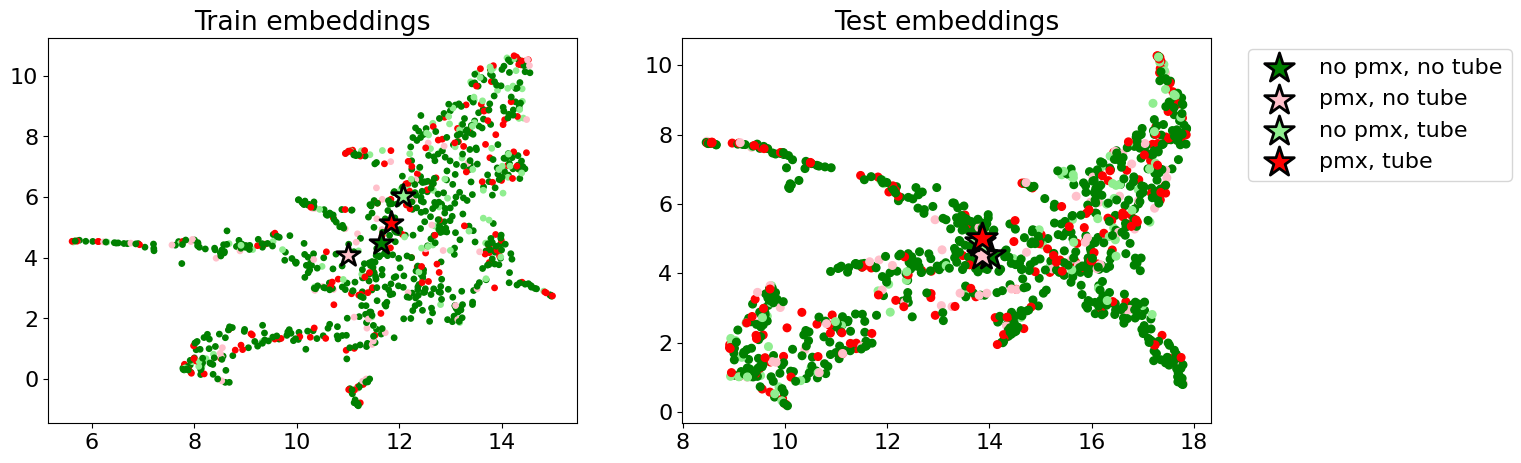

In [52]:
groupid_to_name = ["no pmx, no tube", "pmx, no tube", "no pmx, tube", "pmx, tube"]
groupid_to_color = ["green", "pink", "lightgreen", "red"]

train_group_ids = (2*train_tubes + train_labels).astype(int)
train_names = [groupid_to_name[groupid] for groupid in train_group_ids]
train_colors = [groupid_to_color[groupid] for groupid in train_group_ids]
test_group_ids = (2*test_tubes + test_labels).astype(int)
test_colors = [groupid_to_color[groupid] for groupid in test_group_ids]


centroids_train = np.array([embed_umap_train[train_group_ids==ndx].mean(0) for ndx in range(4)])
centroids_test = np.array([embed_umap_test[test_group_ids==ndx].mean(0) for ndx in range(4)])

fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(embed_umap_train[:,0],embed_umap_train[:,1],c=train_colors,s=15)
for ndx in range(4):
    axs[0].scatter(centroids_train[ndx,0],centroids_train[ndx,1],label=groupid_to_name[ndx],s=300,marker="*",c=groupid_to_color[ndx],edgecolors='k',linewidth=2)
axs[0].set_title("Train embeddings")

axs[1].scatter(embed_umap_test[:,0],embed_umap_test[:,1],c=test_colors,s=30)
axs[1].set_title("Test embeddings")
for ndx in range(4):
    axs[1].scatter(centroids_test[ndx,0],centroids_test[ndx,1],label=groupid_to_name[ndx],s=500,marker="*",c=groupid_to_color[ndx],edgecolors='k',linewidth=2)
axs[1].legend(bbox_to_anchor=(1.05, 1))

plt.show()


## Analyzing correlations in the train set with mimic predictions

In [ ]:
dp_ = dp_erm

train_probs = dp_[train_mask]["output"].data[:,1].sigmoid()
train_labels = dp_[train_mask]["pmx"].data

train_tubes_mask = np.array(dp_[train_mask]["chest_tube"] == 1)

train_notubes_mask = np.array(dp_[train_mask]["chest_tube"] == 0)

train_neg_mask = np.array(dp_[train_mask]["pmx"] == 0)
train_pos_mask = np.array(dp_[train_mask]["pmx"] == 1)

In [ ]:

train_mimic_probs = dp_mimic[train_mask]["output"].data.sigmoid()
train_mimic_probs[:,11] = 0 # remove support devices
train_mimic_probs[:,10] = 0 # remove pmx
#mimic_probs[:,0] = -1e10 # remove atelectasis
#mimic_probs[:,7] = -1e10 # remove pleural_effusion
train_mimic_preds = train_mimic_probs.argmax(1)

In [ ]:
fig,axs = plt.subplots(2,2,sharex=True, sharey=True, figsize=(15,8))


# negatives without tubes
mask = np.logical_and(train_neg_mask,train_notubes_mask)
y_hist, x_hist = np.histogram(train_mimic_preds[mask],bins=np.array(range(15))-0.1,density=True)
axs[0,0].bar(range(14),y_hist)
axs[0,0].set_title(f"Negatives Without Tubes ({mask.sum()})")
print(np.array(100*y_hist).astype(int))

# negatives with tubes
mask = np.logical_and(train_neg_mask,train_tubes_mask)
y_hist, x_hist = np.histogram(train_mimic_preds[mask],bins=np.array(range(15))-0.1,density=True)
axs[0,1].bar(range(14),y_hist)
axs[0,1].set_title(f"Negatives With Tubes ({mask.sum()})")
print(np.array(100*y_hist).astype(int))

# positives without tubes
mask = np.logical_and(train_pos_mask,train_notubes_mask)
y_hist, x_hist = np.histogram(train_mimic_preds[mask],bins=np.array(range(15))-0.1,density=True)
axs[1,0].bar(range(14),y_hist)
axs[1,0].set_title(f"Positives Without Tubes ({mask.sum()})")
print(np.array(100*y_hist).astype(int))

# positives with tubes
mask = np.logical_and(train_pos_mask,train_tubes_mask)
y_hist, x_hist = np.histogram(train_mimic_preds[mask],bins=np.array(range(15))-0.1,density=True)
axs[1,1].bar(range(14),y_hist)
axs[1,1].set_title(f"Positives With Tubes ({mask.sum()})")

axs[1,0].set_xticks(range(14))
axs[1,0].set_xticklabels(mimic_labels,rotation=90)
axs[1,1].set_xticks(range(14))
axs[1,1].set_xticklabels(mimic_labels,rotation=90)
print(np.array(100*y_hist).astype(int))

#plt.xticks(rotation='vertical')
plt.show()

### View gap between mimic classes

In [ ]:
mimic_class = "pleural_effusion"
class_ndx = np.argmax(np.array(mimic_labels)==mimic_class)

test_mimic_probs = dp_mimic[test_mask]["output"].data[:,class_ndx].sigmoid()
test_mimic_preds = np.array(test_mimic_probs > 0.5)

dp_ = dp_erm

train_mask = dp["gaze_seq"].data != "nan"
test_mask = np.logical_and(~train_mask, ~np.isnan(dp["chest_tube"]))

# overall performance
print(f"Overall AUROC: {roc_auc_score(test_labels,test_probs):.3f}")

# AUROC performance on subset that has tube labels
mimic_mask = np.array(test_mimic_preds == 1)
print(f"With {mimic_class} AUROC: {roc_auc_score(test_labels[mimic_mask],test_probs[mimic_mask]):.3f}")

# AUROC performance on subset that has no tube labels
nomimic_mask = np.array(test_mimic_preds == 0)
print(f"Without {mimic_class} AUROC: {roc_auc_score(test_labels[nomimic_mask],test_probs[nomimic_mask]):.3f}")

mimic_in_pos_mask = np.logical_or(neg_mask,np.logical_and(pos_mask,mimic_mask))
nomimic_in_pos_mask = np.logical_or(neg_mask,np.logical_and(pos_mask,nomimic_mask))

print(f"All positives have {mimic_class}, AUROC: {roc_auc_score(test_labels[mimic_in_pos_mask],test_probs[mimic_in_pos_mask]):.3f}")
print(f"All positives have no {mimic_class}, AUROC: {roc_auc_score(test_labels[nomimic_in_pos_mask],test_probs[nomimic_in_pos_mask]):.3f}")

mimic_in_neg_mask = np.logical_or(pos_mask,np.logical_and(neg_mask,mimic_mask))
nomimic_in_neg_mask = np.logical_or(pos_mask,np.logical_and(neg_mask,nomimic_mask))

print(f"All negatives have {mimic_class}, AUROC: {roc_auc_score(test_labels[mimic_in_neg_mask],test_probs[mimic_in_neg_mask]):.3f}")
print(f"All negatives have no {mimic_class}, AUROC: {roc_auc_score(test_labels[nomimic_in_neg_mask],test_probs[nomimic_in_neg_mask]):.3f}")

mask = np.logical_or(np.logical_and(pos_mask,nomimic_mask), np.logical_and(neg_mask,mimic_mask))
print(f"All negatives have {mimic_class}, All positives have no {mimic_class}, AUROC: {roc_auc_score(test_labels[mask],test_probs[mask]):.3f}")

## Analying errors with mimic predictions

In [ ]:
mimic_probs = dp_mimic[test_mask]["output"].data.sigmoid()
mimic_probs[:,11] = 0 # remove support devices
mimic_probs[:,10] = 0 # remove pmx
#mimic_probs[:,0] = -1e10 # remove atelectasis
#mimic_probs[:,7] = -1e10 # remove pleural_effusion
mimic_preds = mimic_probs.argmax(1)

In [ ]:
# find threshold that achieves XX% recall
recall = 0.55
best_thresh = -1
best_recall = -1
for thresh in np.arange(0,1,0.01):
    test_preds_ = test_probs > thresh
    recall_ = recall_score(test_labels,test_preds_)
    if np.abs(recall_-recall) < np.abs(best_recall-recall):
        best_thresh = thresh
        best_recall = recall_

print(best_recall)
print(best_thresh)

In [ ]:
thresh = best_thresh

fig,axs = plt.subplots(2,2,sharex=True, sharey=True, figsize=(15,8))


# negatives without tubes
mask = np.logical_and(neg_mask,notubes_mask)
error_mask = test_probs[mask] > thresh
error_mimic_preds = mimic_preds[mask][error_mask]

y_hist, x_hist = np.histogram(error_mimic_preds,bins=np.array(range(15))-0.1,density=True)
axs[0,0].bar(range(14),y_hist)#/mask.sum())
axs[0,0].set_title(f"Errors in Negatives Without Tubes ({error_mask.sum()}/{mask.sum()})")
#axs[0,0].set_ylabel("Percentage in subset")

print(np.array(100*y_hist).astype(int))

# negatives with tubes
mask = np.logical_and(neg_mask,tubes_mask)
error_mask = test_probs[mask] > thresh
error_mimic_preds = mimic_preds[mask][error_mask]

y_hist, x_hist = np.histogram(error_mimic_preds,bins=np.array(range(15))-0.1,density=True)
axs[0,1].bar(range(14),y_hist)#/mask.sum())
axs[0,1].set_title(f"Errors in Negatives With Tubes ({error_mask.sum()}/{mask.sum()})")
print(np.array(100*y_hist).astype(int))

# positives without tubes
mask = np.logical_and(pos_mask,notubes_mask)
error_mask = test_probs[mask] < thresh
error_mimic_preds = mimic_preds[mask][error_mask]

y_hist, x_hist = np.histogram(error_mimic_preds,bins=np.array(range(15))-0.1,density=True)
axs[1,0].bar(range(14),y_hist)#/mask.sum())
axs[1,0].set_title(f"Errors in Positives Without Tubes ({error_mask.sum()}/{mask.sum()})")
#axs[1,0].set_ylabel("Percentage in subset")

print(np.array(100*y_hist).astype(int))

# positives with tubes
mask = np.logical_and(pos_mask,tubes_mask)
error_mask = test_probs[mask] < thresh
error_mimic_preds = mimic_preds[mask][error_mask]

y_hist, x_hist = np.histogram(error_mimic_preds,bins=np.array(range(15))-0.1,density=True)
axs[1,1].bar(range(14),y_hist)#/mask.sum())
axs[1,1].set_title(f"Errors in Positives With Tubes ({error_mask.sum()}/{mask.sum()})")

axs[1,0].set_xticks(range(14))
axs[1,0].set_xticklabels(mimic_labels,rotation=90)
axs[1,1].set_xticks(range(14))
axs[1,1].set_xticklabels(mimic_labels,rotation=90)
print(np.array(100*y_hist).astype(int))

#plt.xticks(rotation='vertical')
plt.show()